## Simple CNN Models

14/14 [==============================] - 0s 6ms/step
Epoch 1/20
54/54 [==============================] - 3s 28ms/step - loss: 54.0984 - accuracy: 0.4907 - val_loss: 1.5961 - val_accuracy: 0.6157
Epoch 2/20
54/54 [==============================] - 1s 23ms/step - loss: 0.8915 - accuracy: 0.6929 - val_loss: 0.9793 - val_accuracy: 0.6944
Epoch 3/20
54/54 [==============================] - 1s 25ms/step - loss: 0.5951 - accuracy: 0.7520 - val_loss: 0.8449 - val_accuracy: 0.7083
Epoch 4/20
54/54 [==============================] - 1s 21ms/step - loss: 0.4997 - accuracy: 0.7851 - val_loss: 0.8357 - val_accuracy: 0.7292
Epoch 5/20
54/54 [==============================] - 1s 18ms/step - loss: 0.3953 - accuracy: 0.8273 - val_loss: 0.8197 - val_accuracy: 0.7523
Epoch 6/20
54/54 [==============================] - 1s 23ms/step - loss: 0.3206 - accuracy: 0.8662 - val_loss: 0.7230 - val_accuracy: 0.7917
Epoch 7/20
54/54 [==============================] - 1s 21ms/step - loss: 0.2752 - accuracy: 0.9009 -

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


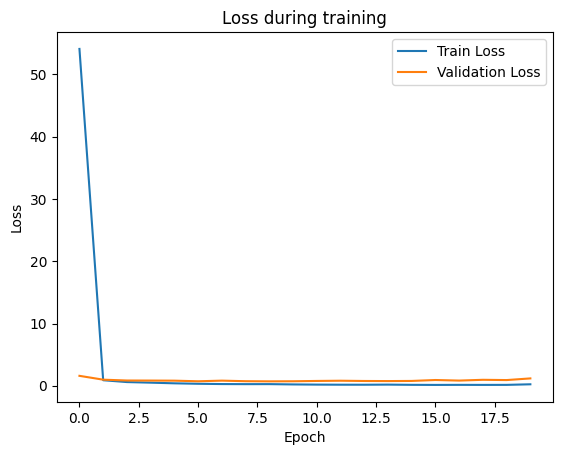

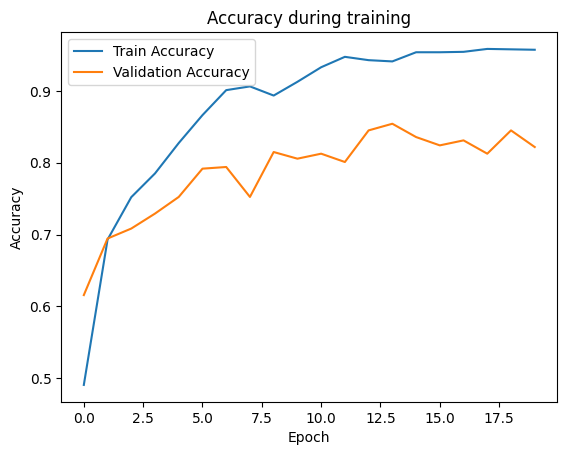

In [12]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2
import matplotlib.pyplot as plt
import os


# Set the paths to your image directories
sphere_datadir = "D:\Sampoerna University\IoT & SU Project\AI Delta Robot\Data Sets\DataSets - 3D\Sphere"
cube_datadir = "D:\Sampoerna University\IoT & SU Project\AI Delta Robot\Data Sets\DataSets - 3D\Cube"
cylinder_datadir = "D:\Sampoerna University\IoT & SU Project\AI Delta Robot\Data Sets\DataSets - 3D\Cylinder"

CATEGORIES = ["Sphere", "Cube", "Cylinder"]

# Function to load and preprocess image data using OpenCV
def load_data(datadir, label):
    X = []
    y = []
    for img in os.listdir(datadir):
        img_array = cv2.imread(os.path.join(datadir, img), cv2.IMREAD_COLOR)
        resized_img = cv2.resize(img_array, (32, 32))  # Resize images to (32, 32)
        X.append(resized_img)
        y.append(label)
    return np.array(X), y

# Load and preprocess image data from different directories
X_sphere, y_sphere = load_data(sphere_datadir, 0)
X_cube, y_cube = load_data(cube_datadir, 1)
X_cylinder, y_cylinder = load_data(cylinder_datadir, 2)

X = np.concatenate((X_sphere, X_cube, X_cylinder), axis=0)
y = np.concatenate((y_sphere, y_cube, y_cylinder), axis=0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Convolutional Neural Network model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Make a predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Save the training model into the laptop directory
model.save("D:\Sampoerna University\IoT & SU Project\AI Delta Robot\Core Program\saved_model.h5")

# Print a confusion matrix for evaluating the model's prediction results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Plot history loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss during training')
plt.show()

# Plot history accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy during training')
plt.show()

In [1]:
import numpy as np
import tensorflow as tf
import cv2

# Load trained model
model = tf.keras.models.load_model("D:/Sampoerna University/IoT & SU Project/AI Delta Robot/Core Program/saved_model.h5")

# Define categories
CATEGORIES = ["Sphere", "Cube", "Cylinder"]

# Develop a function to preprocess frames from the camera feed
def preprocess_frame(frame):
    # Resize the frame to match the input shape of the model
    resized_frame = cv2.resize(frame, (32, 32))
    # Convert frame to array and normalize pixel values
    normalized_frame = resized_frame / 255.0
    # Expand dimensions to match model input shape
    processed_frame = np.expand_dims(normalized_frame, axis=0)
    return processed_frame

# Initialize video capture from default camera
cap = cv2.VideoCapture(0)

# Load the cascade classifier for detecting objects
cascade_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Loop to capture frames from the camera
while True:
    # Read a frame from the camera
    ret, frame = cap.read()

    # Convert the frame to grayscale for object detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect objects in the frame using the cascade classifier
    objects = cascade_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Loop over the detected objects
    for (x, y, w, h) in objects:
        # Extract the object from the frame
        object_roi = frame[y:y+h, x:x+w]

        # Preprocess the object frame
        processed_object = preprocess_frame(object_roi)

        # Make prediction using the model
        predictions = model.predict(processed_object)

        # Get the predicted class and its probability
        predicted_class = np.argmax(predictions)
        probability = np.max(predictions)

        # Draw bounding box around the detected object
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)

        # Display the predicted class and probability in red color
        cv2.putText(frame, "{} ({:.2f})".format(CATEGORIES[predicted_class], probability),
                    (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # Display the x and y positions of the object in red color
        cv2.putText(frame, "X: {}, Y: {}".format(x, y),
                    (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Display the frame
    cv2.imshow('Detected Object', frame)

    # Check for the 'q' key to quit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close OpenCV windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 33ms/step
